# Notebook 34: Optimal sampling of the IGIMF from a grid of galaxies sampled from the GSMF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
import pandas as pd
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
    
import time
    
import sys
sys.path.append('../src/')
from sfr_old import SFZR
from imf import IGIMF
from sampling import OSGIMF, RandomSampling, save_osgimf_instance
from utils import sample_histogram, ZOH_from_FeH, FeH_to_Z, ZOH_to_FeH
from zdf import NeijsselZDF, MetallicityPicker
import constants as ct

In [2]:
DATA_FOLDER = Path('..', 'Data')
OSGIMF_FOLDER = Path(DATA_FOLDER, 'OSGIMFs')
GALAXYGRID_PATH = Path(DATA_FOLDER, 'Galaxy_Grid', 'z0-10-1_5bin_galaxygrid.pkl')

In [3]:
galaxygrid_df = pd.read_pickle(GALAXYGRID_PATH)

In [4]:
galaxygrid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Redshift                            54 non-null     float64
 1   Log(Mgal/Msun)                      54 non-null     float64
 2   Log(Number density [Mpc-3 Msun-1])  54 non-null     float64
 3   SFR [Msun yr-1]                     54 non-null     float64
 4   12+log(O/H)                         54 non-null     float64
 5   [Fe/H]                              54 non-null     float64
dtypes: float64(6)
memory usage: 2.7 KB


In [5]:
galaxygrid_df

,Redshift,Log(Mgal/Msun),Log(Number density [Mpc-3 Msun-1]),SFR [Msun yr-1],12+log(O/H),[Fe/H]
0,0.01,11.003143,-3.239432,0.851880,9.207693,0.755386
1,0.01,10.663365,-2.744230,0.631902,9.190830,0.721660
2,0.01,10.350333,-2.475242,0.432884,9.168100,0.676200
3,0.01,9.934082,-2.241326,0.173025,9.122819,0.585637
4,0.01,7.870006,-1.501990,-1.045828,8.523687,-0.612627
5,1.01,11.004360,-3.402835,1.532782,9.176521,0.693041
6,1.01,10.667811,-2.909475,1.303728,9.140436,0.620872
7,1.01,10.358573,-2.643631,1.097949,9.096570,0.533139
8,1.01,9.947751,-2.415168,0.831028,9.019471,0.378943
9,1.01,7.848946,-1.645590,-0.450232,8.317142,-1.012858


#### Generating one star sample

#### Generating a grid of samples

In [14]:
def get_sample(z, feh, sfr, filepath=None):
    if filepath.is_file():
        print(f'File {filepath} already exists. Skipping...')
        return
    osgimf = OSGIMF(z, feh, sfr, 5, delta_t=1e7, precalculate_limits=False)
    print('Sampling clusters')
    time1 = time.time()
    osgimf.sample_clusters()
    time2 = time.time()
    print(f'Cluster sampling complete. Elapsed time: {time2-time1} s')
    print('Sampling stars')
    time1 = time.time()
    osgimf.sample_stars()
    time2 = time.time()
    print(f'Star sampling complete. Elapsed time: {time2-time1} s')
    print('Saving')
    save_osgimf_instance(osgimf, filepath)

In [ ]:
for row in galaxygrid_df.to_numpy():
    z, logmass, density, logsfr, zoh, feh = row
    filename = f'osgimf_100z{z*100:.0f}_100FeH{100*feh:.0f}_100losfr{100*logsfr:.0f}.pkl'
    filepath = Path(OSGIMF_FOLDER, filename)
    print(f'Now sampling at z = {z}, logSFR = {logsfr}, [Fe/H] = {feh} s')
    start_time = time.time()
    get_sample(z, feh, 10**logsfr, filepath)
    end_time = time.time()
    print(f'Sample saved. Elapsed time: {end_time-start_time} s')
    print(' ')

Now sampling at z = 0.01, logSFR = 0.8518795437284586, [Fe/H] = 0.7553864897636564 s
File ..\Data\OSGIMFs\osgimf_100z1_100FeH76_100losfr85.pkl already exists. Skipping...
Sample saved. Elapsed time: 0.0 s
 
Now sampling at z = 0.01, logSFR = 0.6319016263482723, [Fe/H] = 0.7216602221225621 s
File ..\Data\OSGIMFs\osgimf_100z1_100FeH72_100losfr63.pkl already exists. Skipping...
Sample saved. Elapsed time: 0.0010001659393310547 s
 
Now sampling at z = 0.01, logSFR = 0.43288356559772817, [Fe/H] = 0.6761998813493197 s
File ..\Data\OSGIMFs\osgimf_100z1_100FeH68_100losfr43.pkl already exists. Skipping...
Sample saved. Elapsed time: 0.0 s
 
Now sampling at z = 0.01, logSFR = 0.17302459358096683, [Fe/H] = 0.5856372941605059 s
File ..\Data\OSGIMFs\osgimf_100z1_100FeH59_100losfr17.pkl already exists. Skipping...
Sample saved. Elapsed time: 0.0010154247283935547 s
 
Now sampling at z = 0.01, logSFR = -1.0458277426556235, [Fe/H] = -0.612626593664023 s
File ..\Data\OSGIMFs\osgimf_100z1_100FeH-61_100l

In [34]:
osgimf_files = list(OSGIMF_FOLDER.glob('*.pkl'))

In [35]:
osgimfs = []

for file in osgimf_files:
    with file.open('rb') as f:
        osgimf = pickle.load(f)
    osgimfs.append(osgimf)

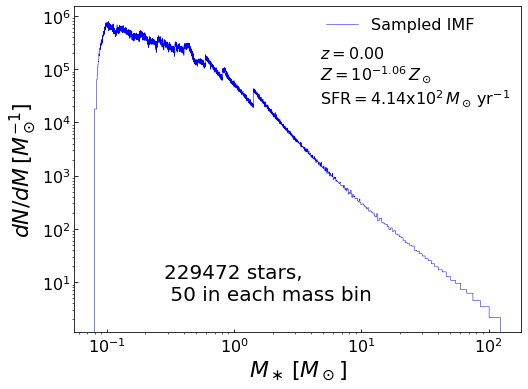

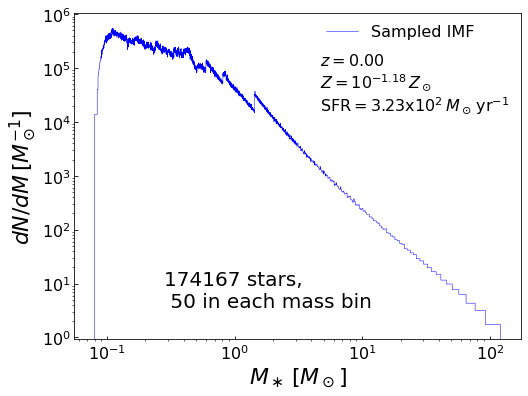

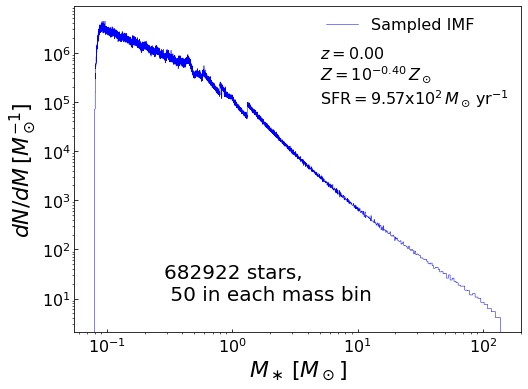

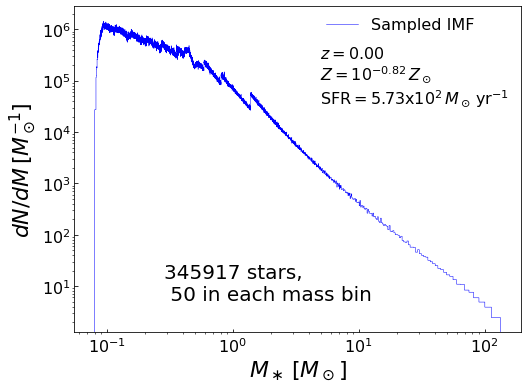

In [67]:
starcount_array = np.empty(0, np.float64)
metallicity_array = np.empty(0, np.float64)

for osgimf in osgimfs:
    fig, ax = plt.subplots(figsize=(8,6))

    osgimf_hist = sample_histogram(osgimf.star_sample, 50)

    ax.plot(osgimf_hist[:,0],osgimf_hist[:,1], 'b-', lw=0.5, label='Sampled IMF')

    ax.set_xlabel(r'$M_\ast\,[M_\odot]$', fontsize=22)
    ax.set_ylabel(r'$dN/dM\,[M_\odot^{-1}]$', fontsize=22)
    #ax.set_title(f'Optimally sampled IGIMF (SFR = {osgimf.sfr:.2e} $M_\odot$yr$^{{-1}}$, [Fe/H]={osgimf.feh:.2f})', fontsize=20)
    ax.legend(loc=(0.55, 0.9), fontsize=16, frameon=False)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.tick_params(axis='both', direction='in', labelsize=16)

    sci_sfr = f'{osgimf.sfr:.2e}'.split('e')
    param_string = f'$z = {osgimf.z:.2f}$\n$Z = 10^{{{osgimf.feh:.2f}}}\,Z_\odot$\n$\mathrm{{SFR}} = {sci_sfr[0]}\mathrm{{x}}10^{{{sci_sfr[1][-1]}}}\,M_\odot\,\mathrm{{yr}}^{{-1}}$'
    
    ax.text(0.55, 0.7, param_string, transform=ax.transAxes, fontsize=16)
    ax.text(0.2, 0.1, f'{osgimf.star_sample.shape[0]} stars, \n 50 in each mass bin', fontsize=20, transform=ax.transAxes)
    
    starcount_array = np.append(star_count_array, osgimf.star_sample.shape[0])
    metallicity_array = np.append(metallicity_array, osgimf.feh)
    
sorted_indexes = np.argsort(metallicity_array)
metallicity_array = metallicity_array[sorted_indexes]
starcount_array = star_count_array[sorted_indexes]

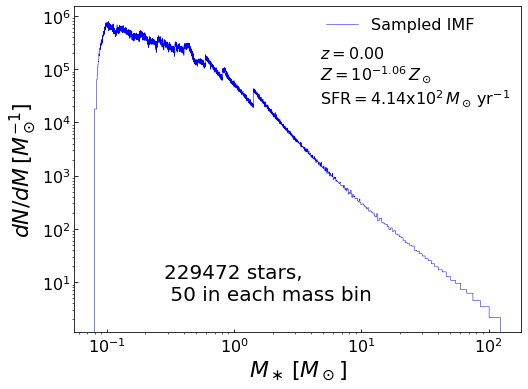

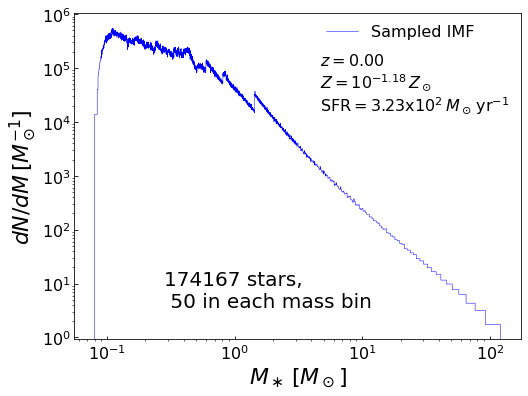

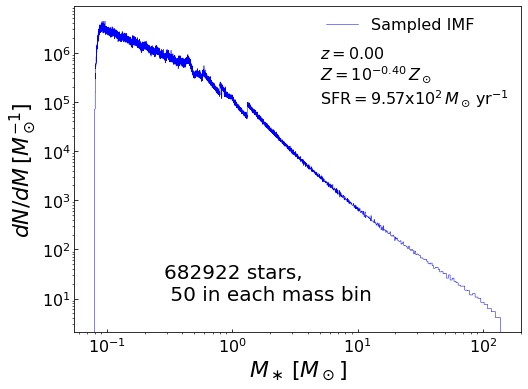

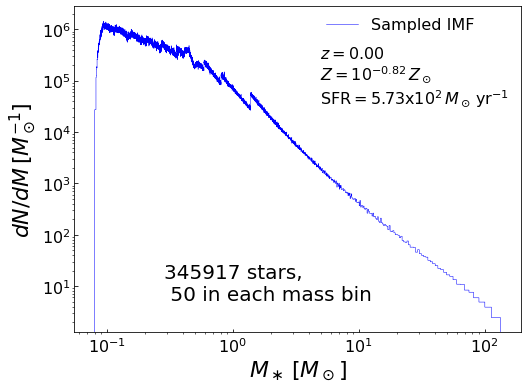

In [67]:
starcount_array = np.empty(0, np.float64)
metallicity_array = np.empty(0, np.float64)

for osgimf in osgimfs:
    fig, ax = plt.subplots(figsize=(8,6))

    osgimf_hist = sample_histogram(osgimf.star_sample, 50)

    ax.plot(osgimf_hist[:,0],osgimf_hist[:,1], 'b-', lw=0.5, label='Sampled IMF')

    ax.set_xlabel(r'$M_\ast\,[M_\odot]$', fontsize=22)
    ax.set_ylabel(r'$dN/dM\,[M_\odot^{-1}]$', fontsize=22)
    #ax.set_title(f'Optimally sampled IGIMF (SFR = {osgimf.sfr:.2e} $M_\odot$yr$^{{-1}}$, [Fe/H]={osgimf.feh:.2f})', fontsize=20)
    ax.legend(loc=(0.55, 0.9), fontsize=16, frameon=False)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.tick_params(axis='both', direction='in', labelsize=16)

    sci_sfr = f'{osgimf.sfr:.2e}'.split('e')
    param_string = f'$z = {osgimf.z:.2f}$\n$Z = 10^{{{osgimf.feh:.2f}}}\,Z_\odot$\n$\mathrm{{SFR}} = {sci_sfr[0]}\mathrm{{x}}10^{{{sci_sfr[1][-1]}}}\,M_\odot\,\mathrm{{yr}}^{{-1}}$'
    
    ax.text(0.55, 0.7, param_string, transform=ax.transAxes, fontsize=16)
    ax.text(0.2, 0.1, f'{osgimf.star_sample.shape[0]} stars, \n 50 in each mass bin', fontsize=20, transform=ax.transAxes)
    
    starcount_array = np.append(star_count_array, osgimf.star_sample.shape[0])
    metallicity_array = np.append(metallicity_array, osgimf.feh)
    
sorted_indexes = np.argsort(metallicity_array)
metallicity_array = metallicity_array[sorted_indexes]
starcount_array = star_count_array[sorted_indexes]